In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import medmnist 
from medmnist import INFO, Evaluator



In [3]:
print(f'MEDMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}')

MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
#data_flag = 'pneumoniamnist'
data_flag = 'organamnist'
# data_flag = 'breastmnist'
download = 'True'

epochs = 20
BATCH_SIZE = 32
lr = 0.001
num_workers = 2 # number of parallel processes for data preparation

info = INFO[data_flag]
task = info['task'] # multiclass
n_channels = info['n_channels'] # 1 channel
n_classes = len(info['label']) # 11 classes
class_names = info['label']
DataClass = getattr(medmnist, info['python_class'])

In [11]:
print (f"The number of classes is: {n_classes} \n The number of channels is {n_channels}.")

The number of classes is: 11 
 The number of channels is 1.


In [14]:
print(f"The class_names are {class_names}")

The class_names are {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}


In [15]:
print(info)

{'python_class': 'OrganAMNIST', 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.', 'url': 'https://zenodo.org/record/6496656/files/organamnist.npz?download=1', 'MD5': '866b832ed4eeba67bfb9edee1d5544e6', 'task': 'multi-class', 'label': {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart

In [32]:
data_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5,9),sigma = (0.1, 5)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[.5])
])


# Load the data
train_dataset = DataClass(split ='train', transform = data_transform, download=download)
test_dataset = DataClass(split='test', transform = data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = num_workers)
train_loader_at_eval = data.DataLoader(dataset = train_dataset, batch_size = 2*BATCH_SIZE, shuffle = False, num_workers = num_workers)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False, num_workers = num_workers)

Using downloaded and verified file: C:\Users\Theodora\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Theodora\.medmnist\organamnist.npz


In [37]:
print(train_dataset)
print('='*50)
print(test_dataset)

Dataset OrganAMNIST (organamnist)
    Number of datapoints: 34581
    Root location: C:\Users\Theodora\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34581, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-cl

### Visualization



In [47]:
train_dataset.montage(length=1)


C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


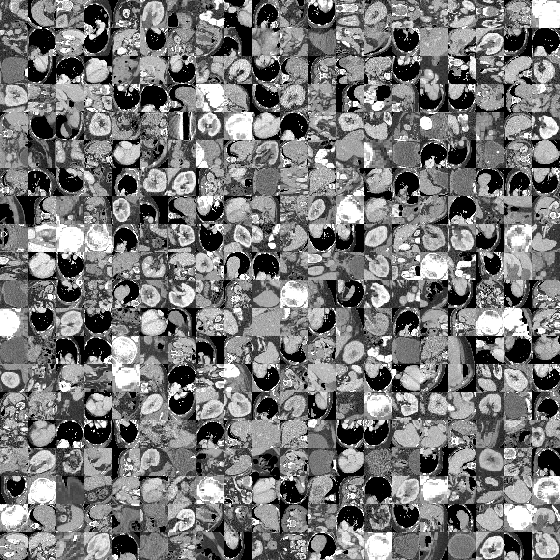

In [48]:
train_dataset.montage(length=20)

[913 489 295]


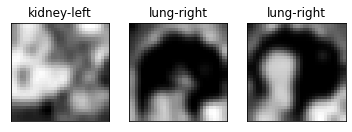

In [157]:
import matplotlib
samples = np.random.choice(1000, 3)
print(samples)
I = len(samples)
matplotlib.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1, 3, figsize=(6, 2*I))


for i in range(I):
    img = train_dataset[samples[i]][0][0]
    lab = train_dataset[samples[i]][1][0]
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(class_names[f"{lab}"])
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    